# Propuesta de procedimiento de diseño de pilotes con carga axial de compresión

### A.O. Sfriso, P. M. Fernández, J. Manduca, M. Biedma, P. M. Barbieri
#### Facultad de Ingeniería de la Universidad de Buenos Aires (2021)

In [27]:
#Librerias
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

### Contribución de la punta

In [28]:
#Capacidad de carga
#Expresión de Brinch - Hansen
def qup_BH(L, D, sigma_eff_vert, c_k, phi_k):
    Nq = (np.exp(np.pi * np.tan(np.radians(phi_k)))) * ((np.tan(0.25 * np.pi + 0.5 * np.radians(phi_k)) ** 2))
    Nc = (Nq - 1) * (1 / np.tan(np.radians(phi_k)))
    
    sc = 1 + (Nq / Nc)
    dc = 1 + 0.40 * (1 / np.tan(np.radians(L/D)))
    
    qup_BH = (c_k * Nc + sigma_eff_vert * Nq) * sc * dc
    
    return qup_BH
    
    
#Expresión de Vesic
def qup_V(sigma_eff_vert, K0, G, c_k, phi_k): 
    p = sigma_eff_vert * (1 + 2 * K0) / 3
    Ir = G / (c_k + p * np.tan(np.radians(phi_k)))
    epsilon_v = 50 * (Ir ** (-1.80)) #Yasufuku 2001
    Irr = Ir / (1 + epsilon_v * Ir)
        
    c1 = (3 / (3 - np.sin(np.radians(phi_k)))) * (np.e ** ((0.5 * np.pi - np.radians(phi_k)) * np.tan(np.radians(phi_k))))
    c3 = (4/3) * (np.sin(np.radians(phi_k)) / (1 + np.sin(np.radians(phi_k))))
    
    N_sigma = c1 * ((np.tan(0.25 * np.pi + 0.5 * np.radians(phi_k))) ** 2) * (Irr ** c3)
    Nc = (1 / np.tan(np.radians(phi_k))) * (((1 + 2 * K0) / 3) * N_sigma - 1)
    
    qup_V = c_k * Nc + p * N_sigma
    
    return qup_V
    
#Carga ultima por la punta
def qup(L, D, sigma_eff_vert, K0, G, c_k, phi_k):
    sigma_eff = sigma_eff_vert
    for i in range(10):
        qup = np.minimum(qup_BH(L, D, sigma_eff_vert, c_k, phi_k), qup_V(sigma_eff_vert, K0, G, c_k, phi_k))
        sigma_eff = qup
    return qup

In [29]:
#Comportamiento p-d (Punta)
def Pp(desp, L, D, sigma_eff_vert, K0, G, nu, c_k, phi_k):
    Rf = 0.99 #Relación de falla
    F = np.pi * (D**2) / 4
    Kp = np.pi * G * D/(1 - nu)
    Pp = desp / (1/Kp + Rf * desp / (F * qup(L, D, sigma_eff_vert, K0, G, c_k, phi_k)))
    return Pp

### Contribución del fuste

In [30]:
#Carga ultima por el fuste
def Qf(L, D, K, NF, gamma_w, gamma_sat, G, c, phi_cv, v, psi):
    n = 10 #Discretización del pilote
    z = 0 #Cota de la cabeza del pilote
    Qf = 0 #Inicializacion de la capacidad de carga por fuste
    
    for i in range(n):
        dz = L / n
        z = z + dz
        if z < NF:
            sigma_eff_v = z * gamma_sat
        else:
            sigma_eff_v = NF * gamma_sat + (z - NF) * (gamma_sat - gamma_w)
        
        delta_sigma_h = np.tan(np.radians(psi)) * v * G / (0.5 * D) 
        sigma_h_f = K * sigma_eff_v + delta_sigma_h
        fi = sigma_h_f * np.sin(np.radians(phi_cv))
        Qfi = fi * np.pi * D * dz
        Qf = Qf + Qfi
        
    return Qf

In [31]:
#Comportamiento p-d (Fuste)
def Pf(desp, L, D, K, NF, gamma_w, gamma_sat, G, c, phi_cv, v, psi):
    Rf = 0.90 #Relación de falla
    rm = 1.5 * L
    Kf = G * L * np.pi * D / (np.log(rm / (0.5 * D))) 
    Pf = desp / (1/Kf + Rf * desp / (Qf(L, D, K, NF, gamma_w, gamma_sat, G, c, phi_cv, v, psi)))
    return Pf

### Resultados

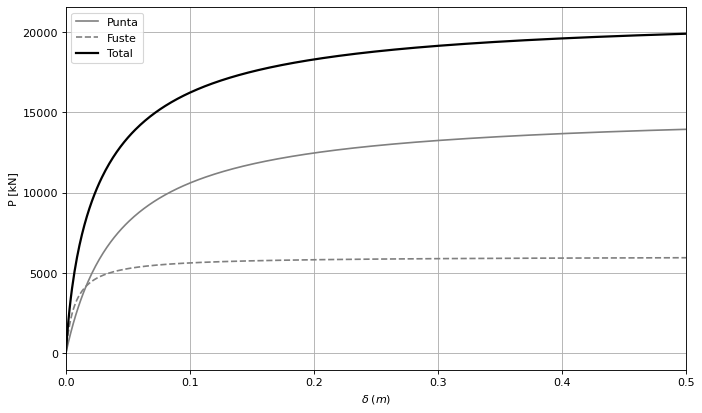

In [35]:
#Datos
L = 10 #Longitud del pilote en (m)
D = 1 # Diametro del pilote en (m)
gamma_sat = 20 #Peso especifico del suelo saturado en (kN/m3)
gamma_w = 10 #Peso especifico del agua en (kN/m3)
sigma_eff_vert = 200 #Tension efectiva vertical en la punta en (kPa)
NF = 30 #Profundidad del nivel freatico en (m)
K0 = 0.50 #Coeficiente de empuje en reposo
K = 1 #Coeficiente de empuje horizontal para el calculo de fricción
G = 90000 #Modulo de rigidez al corte en (kPa)
nu = 0.20 #Coeficiente de Poisson
c_k = 5 #Cohesion efectiva caracteristica en (kPa)
phi_k = 30 #Angulo de fricción en reposo caracteristico en (deg)
psi = 3 #Angulo de dilatancia en (deg)

#Inicializacion de variables
desp = np.linspace(0, 1, 1000)
P = np.zeros(np.size(desp))

#Curva P-d (Punta)
for i in range(np.size(desp)):
    P = Pp(desp, L, D, sigma_eff_vert, K0, G, nu, c_k, phi_k)

#Curva P-d (Fuste)
for i in range(np.size(desp)):
    F = Pf(desp, L, D, K, NF, gamma_w, gamma_sat, G, c_k, phi_k, 0.025, psi)

#Ploteo
figure(figsize=(10, 6), dpi=80)

plt.plot(desp, P, label = 'Punta', color = 'grey', linestyle = '-')
plt.plot(desp, F, label = 'Fuste', color = 'grey', linestyle = '--')
plt.plot(desp, P + F, label = 'Total', color = 'black', linestyle = '-', linewidth = 2)
plt.xlabel('$\delta\;(m)$')
plt.ylabel('P [kN]')
plt.grid()
plt.xlim(0, 0.5)
plt.legend();